In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io, filters
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
load_directory

'/oak/stanford/groups/trc/data/Ilana/2P/data/fly_208/func_0/background_subtraction/functional_channel_2_moco.h5'

In [3]:
%%time

with h5py.File(load_directory, 'r') as hf:
        data = hf['data'][:] 
#         print("Data shape is {}".format(dims))

CPU times: user 7 µs, sys: 11 s, total: 11 s
Wall time: 1min 38s


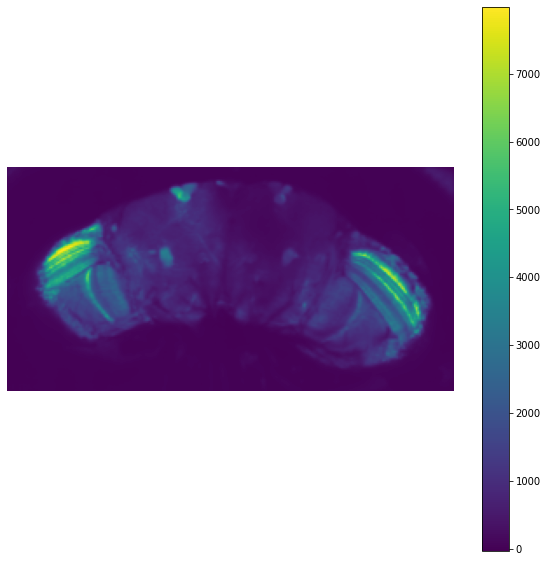

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(data[:,:,20,:],axis=-1).T)
plt.axis('off')
plt.colorbar()

In [5]:
np.where(data==np.min(data))

(array([59]), array([123]), array([28]), array([456]))

In [6]:
def apply_ants_trans(array, moving_resolution, fixed, transforms):
    if array.ndim>3:
        warpst=[]
        for i in range(np.shape(array)[-1]):
    #         to_warp = np.rollaxis(STA_brain[:,tp,:,:],0,4)
            moving = ants.from_numpy(array[...,i])
            moving.set_spacing(moving_resolution)
            moco = ants.apply_transforms(fixed, moving, transforms)
    #         print(moco)
            warped = moco.numpy()
    #         print(warped)
            warpst.append(warped)
    else:
        moving = ants.from_numpy(array)
        moving.set_spacing(moving_resolution)
        moco = ants.apply_transforms(fixed, moving, transforms, interpolator='nearestNeighbor')
#         print(moco)
        warpst = moco.numpy()
    return warpst

In [7]:
def warp_raw_brain(data, steps, fixed, func_path):
    moving_resolution = (2.611, 2.611, 5)
    ###########################
    ### Organize Transforms ###
    ###########################
    warp_directory = os.path.join(func_path,'warp')
    warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
    affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
    affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)
    warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
    syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
    syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
    syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])
    ####transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
    transforms = [syn_nonlinear_path, syn_linear_path, affine_path] ### INVERTED ORDER ON 20220503!!!!
    #ANTS DOCS ARE SHIT. THIS IS PROBABLY CORRECT, AT LEAST IT NOW WORKS FOR THE FLY(134) THAT WAS FAILING

    
    if np.array(data).ndim==4:
        warp_dims=[314, 146, 91, np.shape(data)[-1]]#this probs shouldn't be hard coded but idk what else to do here
        warps = np.zeros(warp_dims)
        ### Warp timeponts
    #     with h5py.File(save_dir, 'w') as f:
    #             dset = f.create_dataset('warps', warp_dims, dtype='float16', chunks=True)         

        for chunk_num in range(len(steps)):
    #                 t0 = time()
            if chunk_num + 1 <= len(steps)-1:
                print(chunk_num)
                chunkstart = steps[chunk_num]
                chunkend = steps[chunk_num + 1]
                chunk = np.array(data[:,:,:,chunkstart:chunkend]).astype(np.float)
                warps_chunk = apply_ants_trans(chunk, moving_resolution, fixed, transforms)
    #             print(np.shape(warps_chunk))
                warps_chunk = np.moveaxis(np.array(warps_chunk),0,-1)
                warps[..., chunkstart:chunkend] = np.nan_to_num(warps_chunk)
    #                     print(F"vol: {chunkstart} to {chunkend} time: {time()-t0}")
    else:
        data = np.array(data).astype(np.float)
        warps = apply_ants_trans(data, moving_resolution, fixed, transforms)
    return warps

In [8]:
def warp_ts(data, fixed, anat_to_mean_type, func_path):
    moving_resolution = (2.611, 2.611, 5)
    ###########################
    ### Organize Transforms ###
    ###########################
    warp_directory = os.path.join(func_path,'warp')
    warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
    affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
    affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)
    if anat_to_mean_type == 'myr':
        warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
    elif anat_to_mean_type == 'non_myr':
        warp_sub_dir = 'anat-to-non_myr_mean_fwdtransforms_2umiso'
    else:
        print('invalid anat_to_mean_type')
        return
    syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
    syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
    syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])
    ####transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
    transforms = [syn_nonlinear_path, syn_linear_path, affine_path] ### INVERTED ORDER ON 20220503!!!!
    #ANTS DOCS ARE SHIT. THIS IS PROBABLY CORRECT, AT LEAST IT NOW WORKS FOR THE FLY(134) THAT WAS FAILING
            
    data = np.array(data).astype(np.float)
    warps = apply_ants_trans(data, moving_resolution, fixed, transforms)
#     warps = np.nan_to_num(data_warp)
    return warps

In [9]:
dims = np.shape(data)
stepsize = 100
steps = list(range(0,dims[-1],stepsize))
steps.append(dims[-1])

In [10]:
dims

(256, 128, 49, 3384)

In [11]:
fixed = brainsss.load_fda_meanbrain()

In [12]:
atlas = brainsss.load_roi_atlas()

In [13]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [14]:
np.shape(data)

(256, 128, 49, 3384)

In [15]:
# moving_resolution = (2.611, 2.611, 5)
# ###########################
# ### Organize Transforms ###
# ###########################
# warp_directory = os.path.join(func_path,'warp')
# # save_dir = os.path.join(warp_directory,  'data_warp_test.h5')#CHANGE THIS ONCE FIXED
# warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
# affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
# affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)
# warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
# syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
# syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
# syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])
# ####transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
# transforms = [syn_nonlinear_path, syn_linear_path, affine_path] ### INVERTED ORDER ON 20220503!!!!

In [16]:
# chunk = np.array(data[:,:,:,:500]).astype(np.float64)
# # print(chunk)
# warps_chunk = apply_ants_trans(chunk, moving_resolution, fixed, transforms)
# print(np.shape(warps_chunk))
# # warps_chunk = np.rollaxis(np.array(warps_chunk),0,4)

In [16]:
timestamps = brainsss.load_timestamps(os.path.join(func_path,'func_0', 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [17]:
np.shape(timestamps)

(3384, 49)

In [18]:
print(np.max(timestamps))
print(np.shape(timestamps[:,10]))

1800264.52452
(3384,)


In [19]:
relative=timestamps[0]-timestamps[0][0]
np.shape(relative)

(49,)

In [20]:
relative

array([  0.     ,   8.72124,  17.44248,  26.16372,  34.88496,  43.6062 ,
        52.32744,  61.04868,  69.76992,  78.49116,  87.2124 ,  95.93364,
       104.65488, 113.37612, 122.09736, 130.8186 , 139.53984, 148.26108,
       156.98232, 165.70356, 174.4248 , 183.14604, 191.86728, 200.58852,
       209.30976, 218.031  , 226.75224, 235.47348, 244.19472, 252.91596,
       261.6372 , 270.35844, 279.07968, 287.80092, 296.52216, 305.2434 ,
       313.96464, 322.68588, 331.40712, 340.12836, 348.8496 , 357.57084,
       366.29208, 375.01332, 383.73456, 392.4558 , 401.17704, 409.89828,
       418.61952])

In [21]:
vals=[]
for ts in range(np.shape(timestamps)[0]):
    val=timestamps[ts]-relative
    vals.append(val[0])
print(np.shape(vals))

(3384,)


In [22]:
print(np.max(vals))
print(np.max(relative))

1799845.9049999998
418.61952


In [23]:
x=np.shape(data)[0]
y=np.shape(data)[1]
ts_xl=[]
for val in relative:
    fframe=np.zeros((x,y))
    fframe.fill(val)
    ts_xl.append(fframe)
ts_xl=np.array(ts_xl)
ts_xl=np.moveaxis(ts_xl,0,-1)
print(np.shape(ts_xl))

(256, 128, 49)


In [29]:
np.array(ts_xl).ndim

3

In [31]:
%%time
warped_ts = warp_raw_brain(data=ts_xl, steps=steps, fixed=fixed, func_path=func_path)

CPU times: user 1.27 s, sys: 186 ms, total: 1.46 s
Wall time: 927 ms


(314, 146, 91)
209.30975
0.0
47.99764


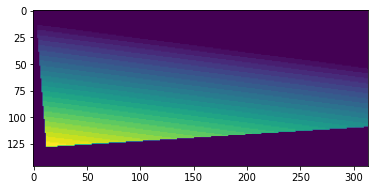

In [32]:
print(np.shape(warped_ts))
print(np.max(warped_ts[...,0]))
print(np.min(warped_ts[...,0]))
print(np.mean(warped_ts[...,0]))
plt.imshow(warped_ts[...,0].T);

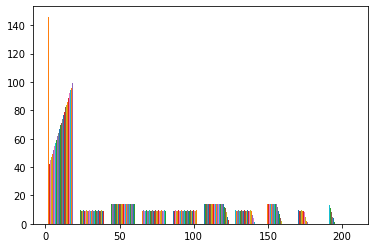

In [32]:
plt.hist(warped_ts[...,0].T);

In [25]:
%%time
total_ts=[]
for i in range(np.shape(vals)[0]):
    temp_ts=warped_ts+vals[i]
#     print(np.shape(temp_ts))
    total_ts.append(temp_ts)
total_ts=np.array(total_ts)
total_ts=np.moveaxis(total_ts,0,-1)

CPU times: user 22 s, sys: 21.1 s, total: 43.1 s
Wall time: 43.1 s


(314, 146, 91, 3384)


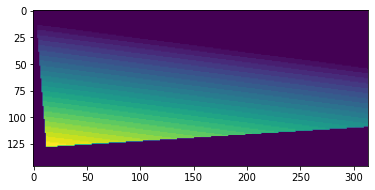

In [26]:
print(np.shape(total_ts))
plt.imshow(np.max(total_ts[...,0,:],axis=-1).T);

In [ ]:
t_start = 1000
t_end = 1500
data_trunc = data[...,t_start:t_end]
ts_trunc=total_ts[...,t_start:t_end]

In [ ]:
%%time
warped = warp_raw_brain(data=data_trunc, steps=steps, fly=fly_num, fixed=fixed, anat_to_mean_type='myr', func_path=func_path)

In [ ]:
print(np.shape(warped))
# warped.astype(np.int)

In [ ]:
warped.dtype

In [ ]:
%%time
warp_directory = os.path.join(func_path,'warp')
save_name = os.path.join(warp_directory,  'test.h5')
with h5py.File(save_name, "w") as data_file:
    data_file.create_dataset("data", data=warped.astype('float32'))
    data_file.create_dataset("timestamps", data=ts_trunc.astype('float32'))

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(warped[:,:,20,:], axis=-1).T)
# plt.imshow(np.max(warped[:,:,:,:], axis=0).T)

In [5]:
%%time
warp_directory = os.path.join(func_path,'warp')
warp_dir = os.path.join(warp_directory,  'test.h5')

with h5py.File(warp_dir, 'r') as hf:
        w = hf['data'][:]
        ts = hf['timestamps'][:]
        dimsw = np.shape(w)
        dimsts = np.shape(ts)
        print("Data shape is {} and timestamps shape is {}".format(dimsw, dimsts))

Data shape is (314, 146, 91, 500) and timestamps shape is (314, 146, 91, 500)
CPU times: user 1.94 ms, sys: 9.13 s, total: 9.13 s
Wall time: 1min 15s


In [ ]:
%%time
warp_directory = os.path.join(func_path,'warp')
warp_dir = os.path.join(warp_directory,  'functional_channel_2_moco_warp.h5')
# warp_dir = os.path.join(warp_directory,  'data_warp_bg.h5')

with h5py.File(warp_dir, 'r') as hf:
        w = hf['data'][:]
#         ts = hf['timestamps'][:]
        dimsw = np.shape(w)
#         dimsts = np.shape(ts)
        print("Data shape is {}".format(dimsw))

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(w[:,:,20,:], axis=-1).T)

NameError: name 'ts' is not defined

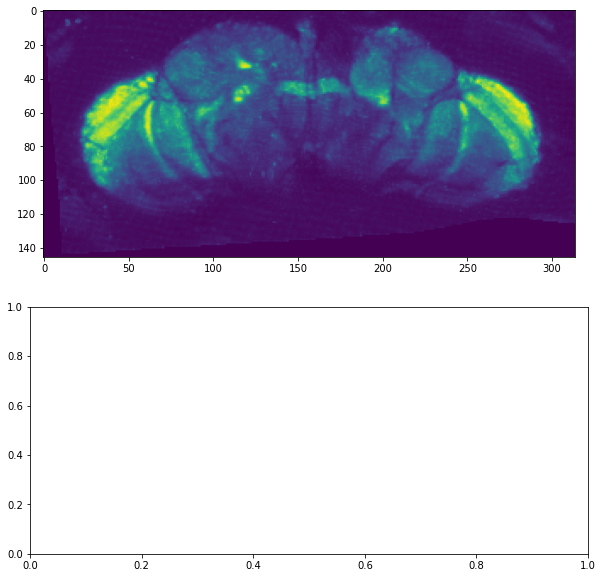

In [4]:
# warped = np.array(warps_chunk)
plt.figure(figsize=(10,10))
# plt.imshow(np.max(np.max(warps[:,:,:,:], axis=-1), axis=-1).T)
plt.subplot(2,1,1)
plt.imshow(np.max(w[:,:,20,:], axis=-1).T)
plt.subplot(2,1,2)
plt.imshow(np.max(ts[:,:,20,:], axis=-1).T)

In [ ]:
warp_dir = os.path.join(func_path, 'warp')
f2a = ants.image_read(os.path.join(warp_dir, 'func-to-anat.nii'))
anat_dir = os.path.join(func_path, 'anat_0', 'moco')
anat = ants.image_read(os.path.join(anat_dir, 'anatomy_channel_1_moc_mean.nii'))
res_anat = (0.653, 0.653, 1)
anat.set_spacing(res_anat)
anat_rs = ants.resample_image(anat,(2,2,2),use_voxels=False)

In [ ]:
anat

In [ ]:
z=70
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(f2a[:,:,z].T)
plt.subplot(2,1,2)
plt.imshow(anat_rs[:,:,z].T)

In [ ]:
a2a = ants.image_read(os.path.join(warp_dir, 'anat-to-meanbrain.nii'))
anat_low=anat.resample_image((2,2,2),use_voxels=False)
np.shape(a2a)

In [ ]:
z=20
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(a2a[:,:,z].T)
plt.subplot(2,1,2)
plt.imshow(fixed[:,:,z].T)

In [ ]:
STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = actual_looms_ms,#null_times_ms, 
                                   neural_bins = neural_bins)

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)